In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,  Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
original_data_dir = '/content/drive/MyDrive/Garbage classification'
base_dir = "processed_dataset"

In [9]:

classes = ["cardboard", "glass", "metal", "paper", "plastic"]


In [10]:
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)


In [11]:
for split in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)


In [12]:
for cls in classes:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.4, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))

print("Dataset organized into train, validation, and test splits.")


Dataset organized into train, validation, and test splits.


In [13]:
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0 / 255.0)


In [14]:
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

Found 1432 images belonging to 5 classes.


In [15]:

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

Found 478 images belonging to 5 classes.


In [16]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

Found 480 images belonging to 5 classes.


In [33]:
from tensorflow.keras.losses import CategoricalCrossentropy
n_classes=len(classes)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

def focal_loss(alpha, gamma):
    def loss(y_true, y_pred):
        ce_loss = CategoricalCrossentropy()(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        fl = alpha * tf.pow(1.0 - pt, gamma) * ce_loss
        return tf.reduce_mean(fl)
    return loss

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)


In [34]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [36]:
history = model.fit(train_gen, validation_data=val_gen, epochs=20,callbacks=[early_stopping, reduce_lr])


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 636ms/step - accuracy: 0.3141 - loss: 0.2750 - val_accuracy: 0.6046 - val_loss: 0.1019 - learning_rate: 1.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.5669 - loss: 0.1140 - val_accuracy: 0.6967 - val_loss: 0.0557 - learning_rate: 1.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.6321 - loss: 0.0792 - val_accuracy: 0.7573 - val_loss: 0.0404 - learning_rate: 1.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.7259 - loss: 0.0476 - val_accuracy: 0.7782 - val_loss: 0.0340 - learning_rate: 1.0000e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.7612 - loss: 0.0408 - val_accuracy: 0.7803 - val_loss: 0.0296 - learning_rate: 1.0000e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.7406 - loss: 0.0377 - val_accuracy: 0.7908 - val_loss: 0.0263 - learning_rate: 1.0000e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accurac

In [43]:
# Fine tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

print("Fine-Tuning...")
history_fine = model.fit(train_gen, validation_data=val_gen,epochs=10,callbacks=[early_stopping, reduce_lr])

Fine-Tuning...
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 693ms/step - accuracy: 0.8686 - loss: 0.0110 - val_accuracy: 0.8515 - val_loss: 0.0144 - learning_rate: 1.0000e-04
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.9160 - loss: 0.0059 - val_accuracy: 0.8389 - val_loss: 0.0128 - learning_rate: 1.0000e-04
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.9220 - loss: 0.0065 - val_accuracy: 0.8389 - val_loss: 0.0128 - learning_rate: 1.0000e-04
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9308 - loss: 0.0039 - val_accuracy: 0.8431 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9468 - loss: 0.0031 - val_accuracy: 0.8515 - val_loss: 0.0115 - learning_rate: 1.0000e-04
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9433 - loss: 0.0033 - val_accuracy: 0.8494 - val_loss: 0.0111 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 129m

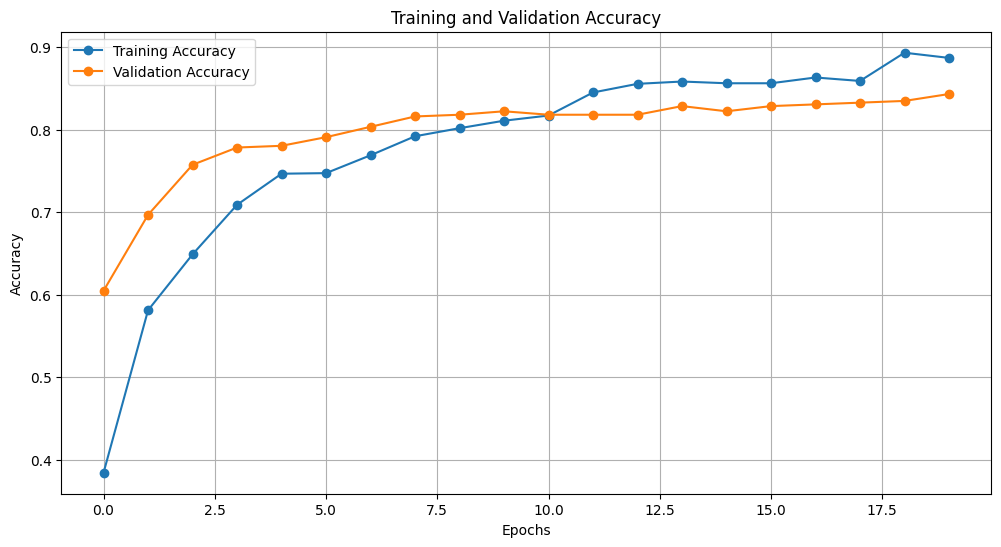

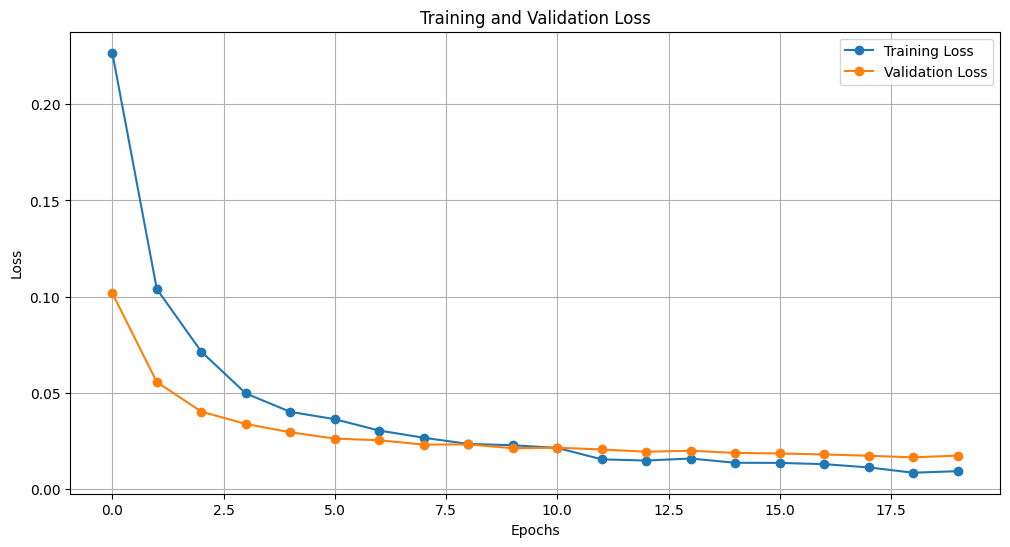

In [50]:
# Extracting metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [44]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8572 - loss: 0.0114
Test Accuracy: 85.00%


In [45]:
model.save('/content/drive/MyDrive/xception_model2.h5')

In [46]:
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step


In [47]:
report = classification_report(y_true, y_pred_classes, target_names=classes)
print(report)


              precision    recall  f1-score   support

   cardboard       0.87      0.88      0.87        81
       glass       0.85      0.80      0.83       101
       metal       0.86      0.94      0.90        82
       paper       0.88      0.88      0.88       119
     plastic       0.80      0.76      0.78        97

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480



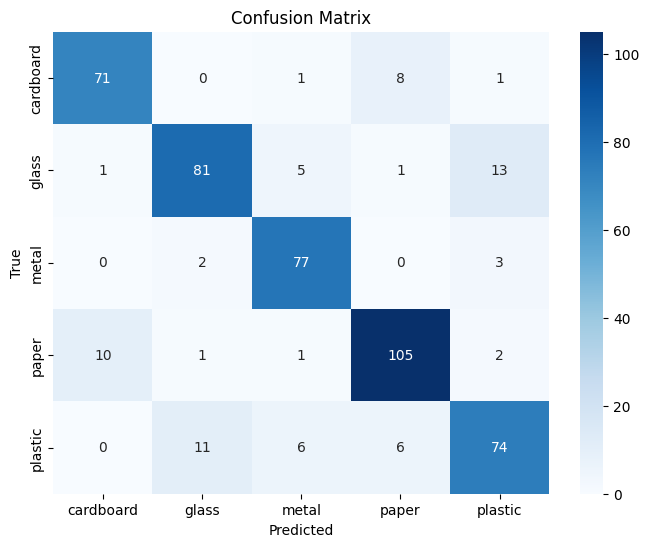

In [48]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


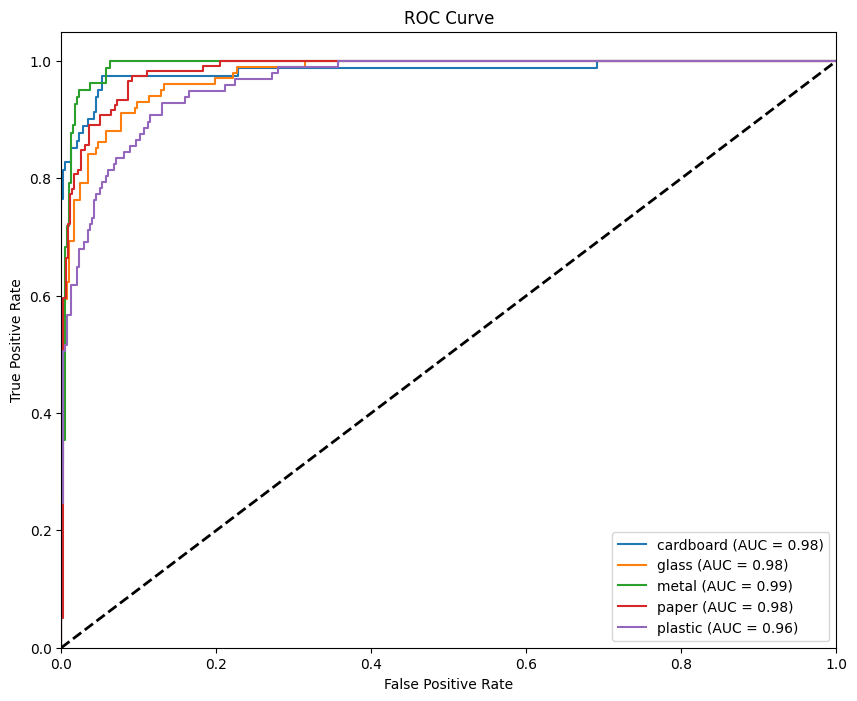

In [49]:
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()